# Performance evaluation of Sea ice thickness retrieval
For the performace evaluation of the sea ice thickness retrieval the Round Robin data Package (RRDP) in version 3.0 from Pedersen et al. 2021, is used. The part of the dataset relevant here is the thin ice reference dataset 
It contains brightness temperatures and thin ice thickness retrieved from SMOS. For this evaluation of the algorithm, it can not be used directly since the 53° degree incidence angle equivalent brightness temperatures are not part of the dataset. We extracted the corresponding locations at the given days from SMOS L1C data in version 7.24. 

In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using Downloads:download
using CSV
using DataFrames
using Optim
using ForwardDiff
using Dates
using YAML
using Printf
using ZipFile
using Statistics
using Markdown

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
#python stuff
using PythonCall
mpl=pyimport("matplotlib")
mpl.use("svg")
plt=pyimport("matplotlib.pyplot")
ccrs=pyimport("cartopy.crs")

Python module: <module 'cartopy.crs' from '/Users/huntemann/SeaIceThickness_ATBD/sit_atbd_env_jl/.CondaPkg/env/lib/python3.10/site-packages/cartopy/crs.py'>

In [3]:
zfn="../data/RRDP_v3.zip"
if !isfile(zfn)
    download("https://figshare.com/ndownloader/files/31422043",zfn)
end

In [4]:
params=YAML.load_file("fit_params.yml")
tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])

fI(x)=I(pI)(x)
fQ(x)=Q(pQ)(x)

ff(p)=x->p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    χ²(y,x,Se)=(y.-F(x))'*(Se\(y.-F(x)))
    χ²(y,x,Se,Sa,xa)=χ²(y,x,Se)+(xa.-x)'*(Sa\(xa.-x))
   if length(xa)==0
        y=[maximize(y->-χ²(Ta,y,Se,Sa,xa),0,10000).res.minimizer]
    else
        res=optimize(y->χ²(Ta,y,Se,Sa,xa),xa)
        y=res.minimizer
    end
    
    M=ForwardDiff.jacobian(F,y)
    yerr=inv(inv(Sa)+M'*inv(Se)*M)
    return y[1],yerr[1]
end
    
Fw_TB(x)=[sit_h(x[1]), sit_v(x[1])]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

c=15
retrieval(h,v)=retrieval([h,v],[25 c;c 25.0],fill(20000.,1,1),[100.],Fw_TB)


retrieval (generic function with 2 methods)

In [5]:
zf=ZipFile.Reader(zfn);
idxs=findall(x->(occursin("RRDP_v3/UB_THINICE/S",x)),getfield.(zf.files,:name))
D=DataFrame[]
for idx in idxs
    push!(D,CSV.read(read(zf.files[idx]),DataFrame;skipto=3,header=2))
#    fio,DataFrame;skipto=3,header=2)
end

allD=vcat(D...);
sort!(allD,["date"]);

d=allD.date[1]
datef=dateformat"yyyymmdd"
Dates.format(d,dateformat"yyyymmdd")

for r in eachrow(allD)
    cday=Dates.format(r.date,datef)
  #  println("$(r.latitude) $(r.longitude) 51/55 $cday $cday")
end
rrdp_extract=CSV.read("../data/rrdp_thinice_51-55_724.txt",DataFrame,header=["date","tbh53","tbv53","mean_inc","tbh53_std","tbv53_std"]);
fulltable=hcat(allD,rrdp_extract,makeunique=true);

In [6]:
function trf(x)
    try 
        return parse(Float64,x)
    catch 
        return NaN
    end
end

nsit=first.(retrieval.(fulltable.tbh53,fulltable.tbv53))
vidx=(.~isnan.(fulltable.tbv53)) .&& (fulltable.SIT.>0) .&& (fulltable.SIT.!=0.51);

In [7]:
d1=fulltable.SIT[vidx]*100.
d2=nsit[vidx]
M=[one.(d1) d1]
p=M\d2 #linear algebra least square fit :-D
r2 = cor(d1,d2)^2

0.6408939277925976

In [8]:
let m=(@sprintf "%.1f" p[2]), r=(@sprintf "%.1f" sqrt(r2)), b=(@sprintf "%.1f" p[1])
md"""
Figure {numref}`fig:refcompare` shows the direct comparison of the reference dataset.
The algorithm shows slightly higher ice thickness. A least square fit result in a slope of $m and y-intersection of $b.
The discrepency might come from the difference in incidence angle or the difference in the data version from the SMOS satellite.
While the original dataset had a fixed upper limit at ``50\ \text{cm}`` ice thickness, the retrieval described here does not have this limit.
The correlation coefficient between the datasets is ``r=`` $r.
"""
end

Figure {numref}`fig:refcompare` shows the direct comparison of the reference dataset. The algorithm shows slightly higher ice thickness. A least square fit result in a slope of 1.5 and y-intersection of -3.0. The discrepency might come from the difference in incidence angle or the difference in the data version from the SMOS satellite. While the original dataset had a fixed upper limit at $50\ \text{cm}$ ice thickness, the retrieval described here does not have this limit. The correlation coefficient between the datasets is $r=$ 0.8.


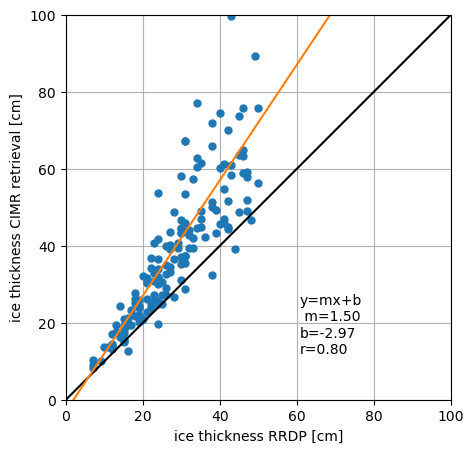

In [9]:
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)
ax.plot(fulltable.SIT[vidx]*100.,nsit[vidx],marker="o",ms=5,lw=0)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.plot([0,100],[0,100],color="k")
x=0:100
ax.plot(x,p[1].+p[2].*x)
ax.annotate((@sprintf "y=mx+b\n m=%.2f\nb=%.2f\nr=%.2f" p[2] p[1] sqrt(r2) ),xy=(0.6,0.2),xycoords="figure fraction",fontsize=10)
ax.set_ylabel("ice thickness CIMR retrieval [cm]")
ax.set_xlabel("ice thickness RRDP [cm]")
ax.set_aspect("equal", adjustable="box")
ax.grid()

#plt.grid()
display(fig)


In Figure {numref}`fig:rrdplocs` the locations an corresponding ice thicknesses are shown which resultet in a valid data point in the comparsion to {numref}`fig:refcompare`. Most data points are coming from the Barents and Kara Seas as well as the Chuckchi Sea, while only few data points come from the Laptev Sea and the Baffin Bay area.

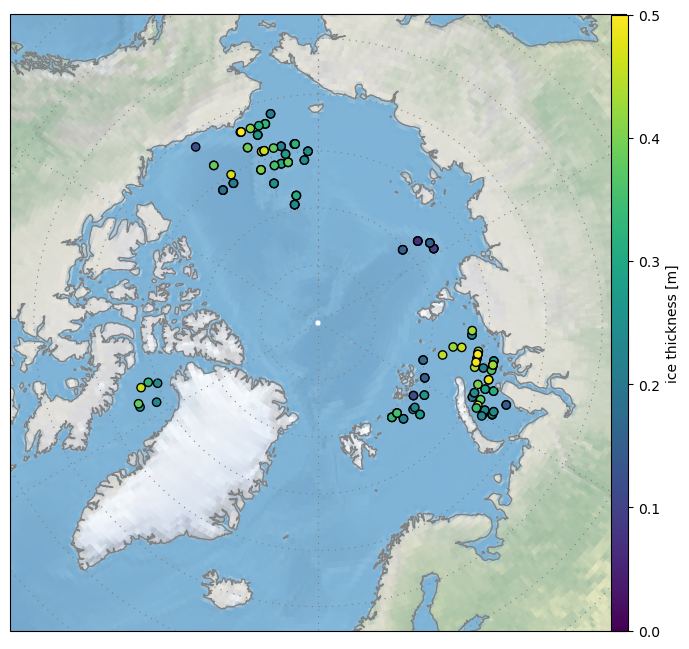

In [10]:
lats=fulltable.latitude
lons=fulltable.longitude;
mapccrs=ccrs.LambertAzimuthalEqualArea(central_latitude=90);
fig=plt.figure(figsize=[8,8])
ax=fig.add_subplot(111,projection=mapccrs)
cax=fig.add_subplot(1,30,30)

ax.set_extent((-3e6,3e6,-3e6,3e6),crs=mapccrs)
ax.stock_img()
ax.coastlines("50m",color="gray")
im=ax.scatter(lons[vidx],lats[vidx],c=fulltable.SIT[vidx],transform=ccrs.PlateCarree(),edgecolor="black",vmin=0,vmax=.50)
ax.gridlines(draw_labels=false,color="gray",linestyle=(0, (1, 5,)))
fig.colorbar(im,cax=cax)
cax.set_ylabel("ice thickness [m]")
display(fig)